# Dogs vs Cats
We'll create a simple cat vs dog classifier.  
Dataset can be downloaded from https://www.floydhub.com/swaroopgrs/datasets/dogscats

**Data**: Labeled images of dogs and cats.  
We want to learn a **classifier**: A function that returns a label (here: `cat`/`dog`) for images

# Read images

In [4]:
import os
dog_dir = 'dogscats/train/dogs'
cat_dir = 'dogscats/train/cats'
dog_paths = os.listdir(dog_dir)
cat_paths = os.listdir(cat_dir)

In [5]:
len(dog_paths), len(cat_paths)

(11500, 11500)

In [6]:
print(dog_paths[:10])

['dog.8011.jpg', 'dog.7322.jpg', 'dog.1753.jpg', 'dog.3144.jpg', 'dog.775.jpg', 'dog.11102.jpg', 'dog.11664.jpg', 'dog.3622.jpg', 'dog.5253.jpg', 'dog.9469.jpg']


In [7]:
# sort the paths
dog_paths.sort()
cat_paths.sort()
print(dog_paths[:10])

dog_paths = [os.path.join(dog_dir, dog_path) for dog_path in dog_paths if dog_path.endswith('.jpg')]
cat_paths = [os.path.join(cat_dir, cat_path) for cat_path in cat_paths if cat_path.endswith('.jpg')]

['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg', 'dog.10000.jpg', 'dog.10002.jpg', 'dog.10003.jpg', 'dog.10004.jpg', 'dog.10006.jpg']


In [8]:
from PIL import Image
def load_images(image_paths, target_size):
    images = []
    ## TODO: Load images from disk, resize to target_size, and return list of images
    ## Pillow library, Image class - open, convert, resize: https://pillow.readthedocs.io/en/stable/reference/Image.html
    for image_path in image_paths:
        image = Image.open(image_path)
        image = image.convert('RGB')
        image = image.resize(target_size)
        images.append(np.array(image))
    return images

In [9]:
# Pillow library for decoding images
import numpy as np

n_imgs = 1200
target_size = (128, 128) # Easier to compare images of the same size

## Load 1200 images for each class
dog_images = load_images(dog_paths[:n_imgs], target_size)
cat_images = load_images(cat_paths[:n_imgs], target_size)

In [10]:
len(dog_images), len(cat_images)

(1200, 1200)

In [11]:
dog_images[0].shape

(128, 128, 3)

In [17]:
dog_images[0]

array([117, 115, 126], dtype=uint8)

# Show some dogs and cats!

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

Use `imshow` function from matplotlib: https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.pyplot.imshow.html

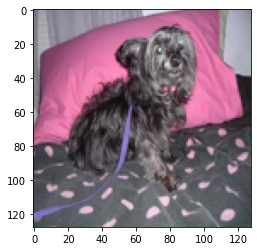

In [19]:
plt.imshow(dog_images[0])

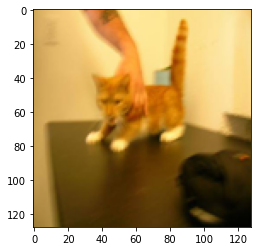

In [20]:
plt.imshow(cat_images[0])

# Simple nearest neighbor classification
We will split our dataset to training set and test set.  
Our model with predict if a test image is of cat or dog based on **a label of the closest image.**  

![nn](nn.png)
*Image source: https://www.kdnuggets.com/2019/07/classifying-heart-disease-using-k-nearest-neighbors.html*

We'll measure **image similarity** as a simple mean **absolute distance between pixel values**.  

\begin{equation}
D(x_{train}, x_{test}) = \frac{1}{|pixels|}\sum_{pixels}{|x_{train}^{pixel} - x_{test}^{pixel}|}
\end{equation}

Nearest neighbors:  
**Training data:** ($x_{train}^i$), corresponding labels $y_{train}^i$  
**Test example:** $x_{test}$. We want to find a prediction for the test example $y_{pred}$.  
**Algorithm**:  
$j= \underset{i}{\mathrm{argmin}} D(x_{train}^i, x_{test})$  
$y_{pred} = y_{train}^{j}$

In [21]:
# img1, img2 - 2 images of the same size
# Return mean absolute distance
def image_dist(img1, img2):
    H, W, C = img1.shape
    distance = 0.
    for i in range(H):
        for j in range(W):
            for c in range(C):
                distance += np.abs(img1[i,j,c] - img2[i,j,c])
    distance = distance / (H * W * C)
    return distance

**^ Don't do this! NumPy is optimized for vectorized operations**

In [22]:
# img1, img2 - 2 images of the same size
def image_dist_vectorized(img1, img2):
    distance = np.mean(np.abs(img1-img2))
    return distance

In [23]:
img1 = dog_images[0].astype(np.float32)
img2 = dog_images[1].astype(np.float32)

In [28]:
%timeit -n 10 image_dist(img1, img2)

81.6 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit -n 10 image_dist_vectorized(img1, img2)

128 µs ± 33.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Prepare the dataset
We need train images, test images, and labels

In [33]:
dog_images = np.array(dog_images).astype(np.float32)
cat_images = np.array(cat_images).astype(np.float32)
print(dog_images.shape, cat_images.shape)

# 4D Tensor of images: NxHxWxC
# N - number of images
# H - height
# W - width
# C - number of channels (RGB)
# (N, H, W, C)

(1200, 128, 128, 3) (1200, 128, 128, 3)


In [31]:
n_train = 1100 # 1100 out of 1200 for training, rest for test
dog_train = dog_images[:n_train]
cat_train = cat_images[:n_train]

dog_test = dog_images[n_train:]
cat_test = cat_images[n_train:]

x_train = np.concatenate((dog_train, cat_train), axis=0)
x_test = np.concatenate((dog_test, cat_test), axis=0)

y_train = ['dog' for i in range(len(dog_train))]
y_train.extend(['cat' for i in range(len(cat_train))])

y_test = ['dog' for i in range(len(dog_test))]
y_test.extend(['cat' for i in range(len(cat_test))])

In [32]:
print('Training set x_train shape: {}, y_train: {}'.format(x_train.shape, len(y_train)))
print('Test set x_test shape: {}, y_test: {}'.format(x_test.shape, len(y_test)))
print('Number of dogs in training set: {}'.format(np.sum(np.array(y_train)=='dog')))

Training set x_train shape: (2200, 128, 128, 3), y_train: 2200
Test set x_test shape: (200, 128, 128, 3), y_test: 200
Number of dogs in training set: 1100


In [34]:
class NNClassifier:
    
    def __init__(self):
        pass
    
    def train(self, images, labels):
        self.images = images
        self.labels = labels
        
    def predict(self, image):
        # Find the closest image, distance to it and its label
        min_distance = np.inf
        min_index = 0
        for idx, train_image in enumerate(self.images):
            distance = image_dist_vectorized(image, train_image)
            if distance < min_distance:
                min_distance = distance
                min_index = idx
        predicted_label = self.labels[min_index]
        closest_image = self.images[min_index]
        return predicted_label, min_distance, closest_image

In [35]:
class NNClassifierVectorized:
    
    def __init__(self):
        pass
    
    def train(self, images, labels):
        self.images = images
        self.labels = labels
        
    def predict(self, image):
        # Find the closest image, distance to it and its label
        distances = np.mean(np.abs(image - self.images), axis=(1,2,3))
        min_index = np.argmin(distances)
        min_distance = distances[min_index]
        predicted_label = self.labels[min_index]
        closest_image = self.images[min_index]
        return predicted_label, min_distance, closest_image

In [36]:
classifier = NNClassifier()
classifier.train(x_train, y_train)

# Classify an image!

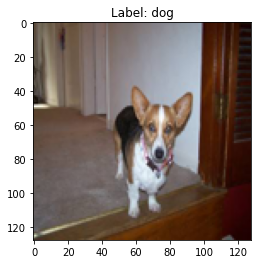

In [46]:
test_ind = 0
plt.imshow(x_test[test_ind] / 255)
plt.title('Label: {}'.format(y_test[test_ind]));

In [47]:
pred_label, min_dist, closest_image = classifier.predict(x_test[test_ind])

In [48]:
closest_image.min()

10.0

Predicted label: dog
Distance: 37.69722366333008


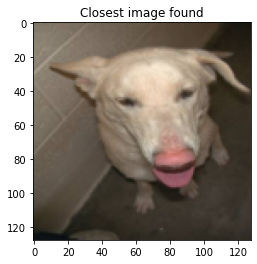

In [49]:
print('Predicted label: {}'.format(pred_label))
print('Distance: {}'.format(min_dist))
plt.imshow(closest_image / 255)
plt.title('Closest image found');

# Evaluate accuracy
How many dogs and cats from test set are classified correctly?

In [50]:
# TODO Run prediction on the entire test set x_test
#      Compute accuracy using predicted labels and true labels y_test
test_predictions = []

In [51]:
from time import time

In [52]:
predicted_labels = []
for image in x_test:
    prediction, _, _ = classifier.predict(image)
    predicted_labels.append(prediction)

In [53]:
y_test = np.array(y_test)
predicted_labels = np.array(predicted_labels)

In [54]:
accuracy = np.sum(y_test==predicted_labels) / len(y_test)
print('Accuracy: {}%'.format(100*accuracy))

Accuracy: 54.0%
